In [9]:
import numpy as np
import pandas as pd

In [10]:
df = pd.read_csv(r'D:\MLOps Projects\Heart-Prediction-Quantum\experiments\Heart Prediction Quantum Dataset.csv')
df.head()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
0,68,1,105,191,107,8.362241,1
1,58,0,97,249,89,9.249002,0
2,44,0,93,190,82,7.942542,1
3,72,1,93,183,101,6.495155,1
4,37,0,145,166,103,7.653900,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    500 non-null    int64  
 1   Gender                 500 non-null    int64  
 2   BloodPressure          500 non-null    int64  
 3   Cholesterol            500 non-null    int64  
 4   HeartRate              500 non-null    int64  
 5   QuantumPatternFeature  500 non-null    float64
 6   HeartDisease           500 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 27.5 KB


In [12]:
df.describe()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,54.864000,0.468000,132.874000,221.50000,88.766000,8.317407,0.600000
std,14.315004,0.499475,26.418516,43.86363,17.417289,0.919629,0.490389
min,30.000000,0.000000,90.000000,150.00000,60.000000,6.164692,0.000000
25%,43.000000,0.000000,111.000000,183.75000,73.000000,7.675779,0.000000
50%,55.000000,0.000000,132.000000,221.00000,89.000000,8.323064,1.000000
75%,66.250000,1.000000,155.000000,258.00000,104.000000,8.935999,1.000000
max,79.000000,1.000000,179.000000,299.00000,119.000000,10.784886,1.000000


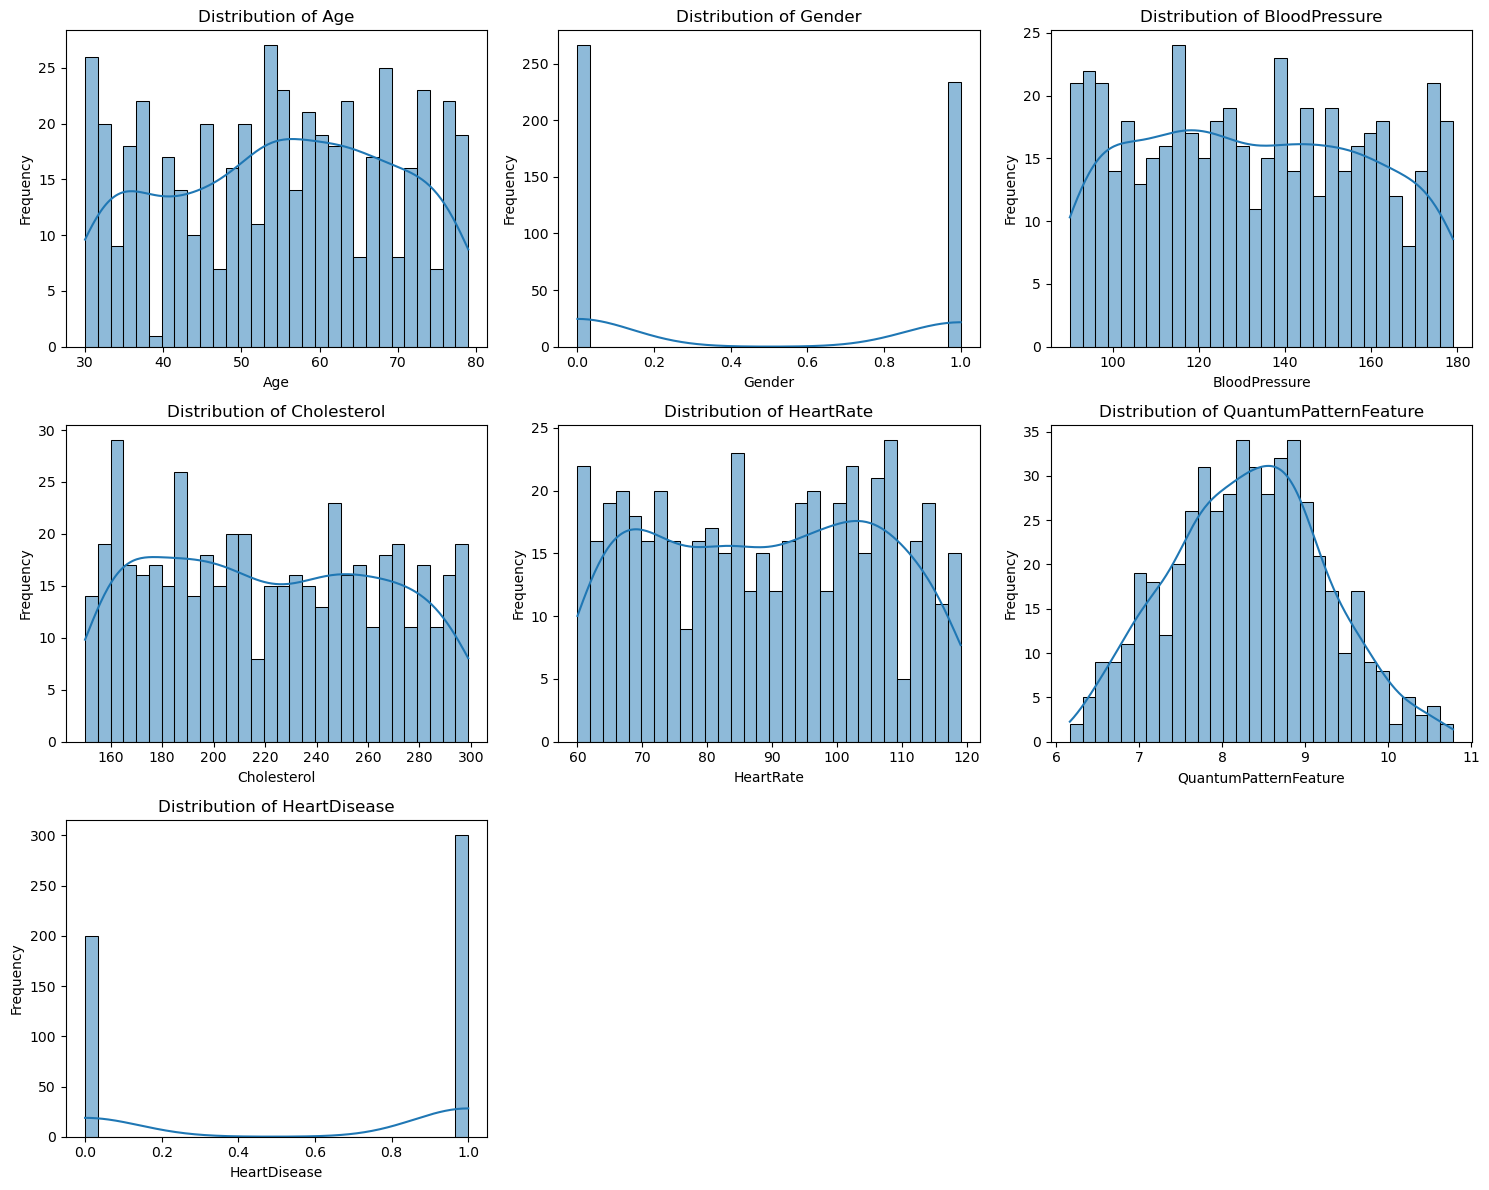

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Automatically plot histograms for all numeric columns
def plot_all_histograms(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    num_cols = len(numeric_cols)
    
    # Calculate rows and columns for subplots
    cols = 3  # You can change this for layout
    rows = (num_cols + cols - 1) // cols

    plt.figure(figsize=(5 * cols, 4 * rows))
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Call the function
plot_all_histograms(df)

In [19]:
import pandas as pd
import numpy as np

def feature_engineer_heart_data(df):
    df_fe = df.copy()

    # ---- Age Bucketing ----
    df_fe['AgeGroup'] = pd.cut(df_fe['Age'], 
                               bins=[0, 39, 49, 59, 69, 79, 150],
                               labels=['<40', '40-49', '50-59', '60-69', '70-79', '80+'])

    # ---- Blood Pressure Categories & Flags ----
    df_fe['BloodPressureCategory'] = pd.cut(df_fe['BloodPressure'],
                                            bins=[0, 119, 129, 139, 1000],
                                            labels=['Normal', 'Elevated', 'Stage1', 'Stage2'])
    df_fe['IsHypertensive'] = (df_fe['BloodPressure'] >= 130).astype(int)
    df_fe['BP_DeltaFromNormal'] = df_fe['BloodPressure'] - 120
    df_fe['BP_per_Age'] = df_fe['BloodPressure'] / df_fe['Age']

    # ---- Cholesterol Categories ----
    df_fe['CholesterolLevel'] = pd.cut(df_fe['Cholesterol'],
                                       bins=[0, 199, 239, 1000],
                                       labels=['Desirable', 'Borderline', 'High'])
    df_fe['Cholesterol_per_Age'] = df_fe['Cholesterol'] / df_fe['Age']

    # ---- Heart Rate Based Features ----
    df_fe['IsTachycardic'] = (df_fe['HeartRate'] > 100).astype(int)
    df_fe['IsBradycardic'] = (df_fe['HeartRate'] < 60).astype(int)
    df_fe['PercentMaxHR'] = df_fe['HeartRate'] / (220 - df_fe['Age'])
    df_fe['HR_per_BP'] = df_fe['HeartRate'] / df_fe['BloodPressure']

    # ---- QuantumPatternFeature Transformations ----
    df_fe['QPF_squared'] = df_fe['QuantumPatternFeature'] ** 2
    df_fe['QPF_log'] = np.log1p(df_fe['QuantumPatternFeature'])

    # ---- Interaction Features ----
    df_fe['Age_Cholesterol'] = df_fe['Age'] * df_fe['Cholesterol']
    df_fe['Age_BP'] = df_fe['Age'] * df_fe['BloodPressure']
    df_fe['BP_Cholesterol'] = df_fe['BloodPressure'] * df_fe['Cholesterol']
    df_fe['Cholesterol_minus_BP'] = df_fe['Cholesterol'] - df_fe['BloodPressure']
    df_fe['HR_Cholesterol'] = df_fe['HeartRate'] * df_fe['Cholesterol']

    # ---- Clinical Risk Proxy Score ----
    df_fe['ClinicalRiskScore'] = (
        0.02 * df_fe['Age'] +
        0.03 * df_fe['BloodPressure'] +
        0.04 * df_fe['Cholesterol'] +
        0.05 * df_fe['HeartRate']
    )

    # ---- One-Hot Encode categorical columns as int ----
    cat_cols = df_fe.select_dtypes(include=['category', 'object']).columns
    df_fe = pd.get_dummies(df_fe, columns=cat_cols, drop_first=True)
    df_fe = df_fe.astype({col: 'int' for col in df_fe.columns if df_fe[col].nunique() == 2 and df_fe[col].dtype != 'int'})

    return df_fe

In [20]:
df_fe = feature_engineer_heart_data(df)
df_fe.head()

,Age,Gender,BloodPressure,Cholesterol,HeartRate,QuantumPatternFeature,HeartDisease,IsHypertensive,BP_DeltaFromNormal,BP_per_Age,...,AgeGroup_40-49,AgeGroup_50-59,AgeGroup_60-69,AgeGroup_70-79,AgeGroup_80+,BloodPressureCategory_Elevated,BloodPressureCategory_Stage1,BloodPressureCategory_Stage2,CholesterolLevel_Borderline,CholesterolLevel_High
0,68,1,105,191,107,8.362241,1,0,-15,1.544118,...,0,0,1,0,False,0,0,0,0,0
1,58,0,97,249,89,9.249002,0,0,-23,1.672414,...,0,1,0,0,False,0,0,0,0,1
2,44,0,93,190,82,7.942542,1,0,-27,2.113636,...,1,0,0,0,False,0,0,0,0,0
3,72,1,93,183,101,6.495155,1,0,-27,1.291667,...,0,0,0,1,False,0,0,0,0,0
4,37,0,145,166,103,7.653900,1,1,25,3.918919,...,0,0,0,0,False,0,0,1,0,0


In [24]:
from sklearn.model_selection import train_test_split

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

# Instantiate all models
models = {
    "Logistic Regression"     : LogisticRegression(),
    "K-Nearest Neighbors"     : KNeighborsClassifier(),
    "Decision Tree"           : DecisionTreeClassifier(),
    "Random Forest"           : RandomForestClassifier(),
    "Gradient Boosting"       : GradientBoostingClassifier(),
    "AdaBoost"                : AdaBoostClassifier(),
    "SVM (RBF Kernel)"        : SVC(probability=True),
    "Naive Bayes"             : GaussianNB(),
    "XGBoost"                 : XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM"                : LGBMClassifier(),
    "CatBoost"                : CatBoostClassifier(verbose=0)
}

def evaluate_classifiers(X_train, y_train, X_test, y_test):
    print("\n🎯 Model Evaluation Leaderboard\n" + "="*90)
    
    for name, model in models.items():
        print(f"\n🧠 Model: \033[1m{name}\033[0m")
        print("-" * 90)
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_proba = None

            acc  = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec  = recall_score(y_test, y_pred)
            f1   = f1_score(y_test, y_pred)

            try:
                roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
            except:
                roc_auc = None

            # Cross-validation
            try:
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
                cv_score_str = f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"
            except Exception as e:
                cv_score_str = f"Failed (✗): {str(e).splitlines()[0]}"

            # Display results
            print(f"🔹 Accuracy       : {acc:.4f}")
            print(f"🔹 Precision      : {prec:.4f}")
            print(f"🔹 Recall         : {rec:.4f}")
            print(f"🔹 F1 Score       : {f1:.4f}")
            print(f"🔹 ROC AUC        : {roc_auc:.4f} {'✓' if roc_auc is not None else '✗'}")
            print(f"🔹 CV Accuracy    : {cv_score_str}")

            print("\n📊 Classification Report")
            print("-" * 90)
            print(classification_report(y_test, y_pred))
        except Exception as e:
            print(f"❌ Failed to evaluate model '{name}': {str(e).splitlines()[0]}")
        
        print("=" * 90)

# Usage
evaluate_classifiers(X_train, y_train, X_test, y_test)


🎯 Model Evaluation Leaderboard

🧠 Model: Logistic Regression
------------------------------------------------------------------------------------------
🔹 Accuracy       : 0.9520
🔹 Precision      : 0.9275
🔹 Recall         : 0.9846
🔹 F1 Score       : 0.9552
🔹 ROC AUC        : 0.9931 ✓
🔹 CV Accuracy    : 0.9120 ± 0.0065

📊 Classification Report
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        60
           1       0.93      0.98      0.96        65

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.95      0.95      0.95       125


🧠 Model: K-Nearest Neighbors
------------------------------------------------------------------------------------------
🔹 Accuracy       : 0.7040
🔹 Precision      : 0.7000
🔹 Recall         : 0.7538
🔹 F1 Score       : 0.7259
🔹 ROC AUC   

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris

# Define Optuna objective function for tuning Logistic Regression hyperparameters
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-5, 100)
    penalty = trial.suggest_categorical('penalty', ['l2'])  # We restrict this to 'l2' for simplicity
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])

    # Create and train Logistic Regression model
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000, random_state=42)
    
    # Perform cross-validation and calculate the accuracy
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return score

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")
print(f"Best cross-validation accuracy: {study.best_value:.4f}")

# Train the Logistic Regression model with the best hyperparameters
best_params = study.best_params
model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'], max_iter=1000, random_state=42)

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Check for probability estimates (for ROC AUC)
y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr') if y_proba is not None else None

# Cross-validation score (using best model)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
cv_score_str = f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"

# Print the results
print("\n🎯 Model Evaluation (Logistic Regression with Hyperparameter Tuning)\n" + "="*90)
print(f"🔹 Accuracy       : {acc:.4f}")
print(f"🔹 Precision      : {prec:.4f}")
print(f"🔹 Recall         : {rec:.4f}")
print(f"🔹 F1 Score       : {f1:.4f}")
print(f"🔹 ROC AUC        : {roc_auc:.4f} {'✓' if roc_auc is not None else '✗'}")
print(f"🔹 CV Accuracy    : {cv_score_str}")

print("\n📊 Classification Report")
print("-" * 90)
print(classification_report(y_test, y_pred))
print("=" * 90)